<a href="https://colab.research.google.com/github/ozturkergin/ozturkergin/blob/main/TEFAS_Fon_Analiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import & Install

In [1]:
pip install marshmallow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.8 MB/s eta 0:00:00


In [2]:
pip install PyPortfolioOpt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.5 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import requests
import pandas as pd
import math

from datetime import datetime, timedelta, date
from typing import Dict, List, Optional, Union
from marshmallow import Schema, fields, EXCLUDE, pre_load, post_load


In [4]:
# Special thanks to https://github.com/burakyilmaz321

class InfoSchema(Schema):
    date = fields.Date(data_key="TARIH", allow_none=True)
    price = fields.Float(data_key="FIYAT", allow_none=True)
    code = fields.String(data_key="FONKODU", allow_none=True)
    title = fields.String(data_key="FONUNVAN", allow_none=True)
    market_cap = fields.Float(data_key="PORTFOYBUYUKLUK", allow_none=True)
    number_of_shares = fields.Float(data_key="TEDPAYSAYISI", allow_none=True)
    number_of_investors = fields.Float(data_key="KISISAYISI", allow_none=True)

    # pylint: disable=no-self-use
    # pylint: disable=unused-argument
    @pre_load
    def pre_load_hook(self, input_data, **kwargs):
        # Convert milliseconds Unix timestamp to date
        seconds_timestamp = int(input_data["TARIH"]) / 1000
        input_data["TARIH"] = date.fromtimestamp(seconds_timestamp).isoformat()
        return input_data

    @post_load
    def post_load_hool(self, output_data, **kwargs):
        # Fill missing fields with default None
        output_data = {f: output_data.setdefault(f) for f in self.fields}
        return output_data

    # pylint: enable=no-self-use
    # pylint: enable=unused-argument

    class Meta:
        unknown = EXCLUDE

class BreakdownSchema(Schema):
    date = fields.Date(data_key="TARIH", allow_none=True)
    tmm = fields.Float(data_key="TMM (%)", allow_none=True)
    repo = fields.Float(data_key="R", allow_none=True)
    code = fields.String(data_key="FONKODU", allow_none=True)
    other = fields.Float(data_key="D", allow_none=True)
    stock = fields.Float(data_key="HS", allow_none=True)
    eurobonds = fields.Float(data_key="EUT", allow_none=True)
    bank_bills = fields.Float(data_key="BB", allow_none=True)
    derivatives = fields.Float(data_key="T", allow_none=True)
    reverse_repo = fields.Float(data_key="TR", allow_none=True)
    term_deposit = fields.Float(data_key="VM", allow_none=True)
    treasury_bill = fields.Float(data_key="HB", allow_none=True)
    foreign_equity = fields.Float(data_key="YHS", allow_none=True)
    government_bond = fields.Float(data_key="DT", allow_none=True)
    precious_metals = fields.Float(data_key="KM", allow_none=True)
    commercial_paper = fields.Float(data_key="FB", allow_none=True)
    fx_payable_bills = fields.Float(data_key="DB", allow_none=True)
    foreign_securities = fields.Float(data_key="YMK", allow_none=True)
    private_sector_bond = fields.Float(data_key="OST", allow_none=True)
    participation_account = fields.Float(data_key="KH", allow_none=True)
    foreign_currency_bills = fields.Float(data_key="DÖT", allow_none=True)
    asset_backed_securities = fields.Float(data_key="VDM", allow_none=True)
    real_estate_certificate = fields.Float(data_key="GAS", allow_none=True)
    foreign_debt_instruments = fields.Float(data_key="YBA", allow_none=True)
    government_lease_certificates = fields.Float(data_key="KKS", allow_none=True)
    fund_participation_certificate = fields.Float(data_key="FKB", allow_none=True)
    government_bonds_and_bills_fx = fields.Float(data_key="KBA", allow_none=True)
    private_sector_lease_certificates = fields.Float(data_key="OSKS", allow_none=True)

    # pylint: disable=no-self-use
    # pylint: disable=unused-argument
    @pre_load
    def pre_load_hook(self, input_data, **kwargs):
        # Convert milliseconds Unix timestamp to date
        seconds_timestamp = int(input_data["TARIH"]) / 1000
        input_data["TARIH"] = date.fromtimestamp(seconds_timestamp).isoformat()
        return input_data

    @post_load
    def post_load_hook(self, output_data, **kwargs):
        # Replace None values with 0 for float fields
        output_data = {
            k: v
            if not (isinstance(self.fields[k], fields.Float) and v is None)
            else 0.0
            for k, v in output_data.items()
        }
        # Fill missing fields with default None
        output_data = {f: output_data.setdefault(f) for f in self.fields}
        return output_data

    # pylint: enable=no-self-use
    # pylint: enable=unused-argument

    class Meta:
        unknown = EXCLUDE

class tefas_get:

    root_url = "http://www.fundturkey.com.tr"
    detail_endpoint = "/api/DB/BindHistoryAllocation"
    info_endpoint = "/api/DB/BindHistoryInfo"
    headers = {
        "Connection": "keep-alive",
        "X-Requested-With": "XMLHttpRequest",
        "User-Agent": (
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36"
        ),
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
        "Accept": "application/json, text/javascript, */*; q=0.01",
        "Origin": "http://www.fundturkey.com.tr",
        "Referer": "http://www.fundturkey.com.tr/TarihselVeriler.aspx",
    }

    def __init__(self):
        self.session = requests.Session()
        _ = self.session.get(self.root_url)
        self.cookies = self.session.cookies.get_dict()

    def fetch(
        self,
        start: Union[str, datetime],
        end: Optional[Union[str, datetime]] = None,
        name: Optional[str] = None,
        columns: Optional[List[str]] = None,
    ) -> pd.DataFrame:

        start_date_initial = datetime.strptime(start, "%Y-%m-%d")
        end_date_initial = datetime.strptime(end or start, "%Y-%m-%d")
        counter = 1
        start_date = start_date_initial
        end_date = end_date_initial

        range_date = end_date_initial - start_date_initial
        range_interval = 90
        #print(range_date.days)

        info_schema = InfoSchema(many=True)
        # detail_schema = BreakdownSchema(many=True)
        merged = pd.DataFrame()

        if range_date.days > range_interval :
          counter = range_date.days / range_interval
          counter = math.ceil(counter)
          end_date = start_date + timedelta(days=range_interval)

        while counter > 0:
          counter -= 1
          #print(counter)
          #print(start_date)
          #print(end_date)

          data = {
              "fontip": "YAT",
              "bastarih": _parse_date(start_date),
              "bittarih": _parse_date(end_date),
              "fonkod": name.upper() if name else "",
          }

          # General info pane
          info = self._do_post(self.info_endpoint, data)
          info = info_schema.load(info)
          info = pd.DataFrame(info, columns=info_schema.fields.keys())
          #print(info)

          # Portfolio breakdown pane
          #detail = self._do_post(self.detail_endpoint, data)
          #detail = detail_schema.load(detail)
          #detail = pd.DataFrame(detail, columns=detail_schema.fields.keys())
          #print(detail)

          merged = pd.concat([merged, info])

          # Return only desired columns
          merged = merged[columns] if columns else merged

          if counter > 0 :
            start_date = end_date + timedelta(days=1)
            end_date = end_date + timedelta(days=range_interval)
            if end_date > end_date_initial :
              end_date = end_date_initial

        return merged

    def _do_post(self, endpoint: str, data: Dict[str, str]) -> Dict[str, str]:
        # TODO: error handling. this is quiet fishy now.
        response = self.session.post(
            url=f"{self.root_url}/{endpoint}",
            data=data,
            cookies=self.cookies,
            headers=self.headers,
        )
        return response.json().get("data", {})

def _parse_date(date: Union[str, datetime]) -> str:
    if isinstance(date, datetime):
        formatted = datetime.strftime(date, "%d.%m.%Y")
    elif isinstance(date, str):
        try:
            parsed = datetime.strptime(date, "%Y-%m-%d")
        except ValueError as exc:
            raise ValueError(
                "Date string format is incorrect. " "It should be `YYYY-MM-DD`"
            ) from exc
        else:
            formatted = datetime.strftime(parsed, "%d.%m.%Y")
    else:
        raise ValueError(
            "`date` should be a string like 'YYYY-MM-DD' "
            "or a `datetime.datetime` object."
        )
    return formatted


# Define Date for Analysis

In [8]:
time_delta = 365
print('Input # days to specify start date:')
try:
  time_delta = int(input())
except ValueError:
  print("Invalid input. Please enter a valid integer.")

start_date_calc = date.today() - timedelta(days=time_delta)
print("Start date will be "+ str(start_date_calc))

Input # days to specify start date:
85
Start date will be 2023-05-31


# Extract Data

In [9]:
# Get Gold Prices from Yahoo Finance
df_fetch_gold = yf.download('GC=F', start_date_calc.strftime("%Y-%m-%d"), date.today().strftime("%Y-%m-%d"), progress=False)
df_Gold = df_fetch_gold[['Close']].rename(columns={'Close': 'GOLD'})
df_Gold['CalDay'] = df_Gold.index.strftime('%Y-%m-%d')
df_Gold.set_index(['CalDay'], inplace=True)
df_Gold

,GOLD
CalDay,
2023-05-31,1963.900024
2023-06-01,1978.000000
2023-06-02,1952.400024
2023-06-05,1958.000000
2023-06-06,1965.500000
2023-06-07,1942.699951
2023-06-08,1963.599976
2023-06-09,1962.199951
2023-06-12,1955.300049


In [10]:
# Get TRY/USD Prices from Yahoo Finance
df_fetch_USDTRY = yf.download('USDTRY=X', start_date_calc.strftime("%Y-%m-%d"), date.today().strftime("%Y-%m-%d"), progress=False, interval="1d")
df_USDTRY = df_fetch_USDTRY[['Close']].rename(columns = {'Close': 'USDTRY'})
df_USDTRY['CalDay'] = df_USDTRY.index.strftime('%Y-%m-%d')
df_USDTRY.set_index(['CalDay'], inplace=True)
df_USDTRY

,USDTRY
CalDay,
2023-05-31,20.611601
2023-06-01,20.786400
2023-06-02,20.890200
2023-06-05,21.080299
2023-06-06,21.269501
...,...
2023-08-18,27.125000
2023-08-21,27.138399
2023-08-22,27.205500


In [11]:
tefas = tefas_get()

assets = ['AKU','ST1','AFO', 'OJK', 'AFT', 'ALE', 'AOY', 'GOH', 'GUM']

today_1_year_ago = date.today() - timedelta(days=time_delta)
date_start = today_1_year_ago.strftime("%Y-%m-%d")
date_end = date.today().strftime("%Y-%m-%d")

df = pd.DataFrame()
fetched_data = pd.DataFrame()

for fon in assets:
#  print(fon)
  fetched_data = tefas.fetch(start=date_start, end=date_end, name=fon, columns=["date", "price"])
  fetched_data['CalDay'] = pd.to_datetime(fetched_data['date'], errors='coerce')
  fetched_data['CalDay'] = fetched_data['CalDay'].dt.strftime('%Y-%m-%d')
  fetched_data.set_index(['CalDay'], inplace=True)
  fetched_data.drop(['date'], axis=1)
  new_df = pd.DataFrame(fetched_data)
  new_df.drop(['date'], axis=1)
  new_df.rename(columns = {'price': fon}, inplace=True)
  df = pd.concat([df, new_df])
  df.fillna(0,inplace=True)

df = df.groupby(['CalDay']).sum(numeric_only=True)

df = pd.merge(df, df_USDTRY, left_index=True, right_index=True, how='outer')
df.fillna(inplace=True,method='ffill')
df.fillna(inplace=True,method='bfill')

df = pd.merge(df, df_Gold, left_index=True, right_index=True, how='outer')
df.fillna(inplace=True,method='ffill')
df.fillna(inplace=True,method='bfill')

df

,AKU,ST1,AFO,OJK,AFT,ALE,AOY,GOH,GUM,USDTRY,GOLD
CalDay,,,,,,,,,,,
2023-05-31,0.306413,70.677874,0.283863,2.572164,0.205888,3.617218,0.171455,4.473173,2.185782,20.611601,1963.900024
2023-06-01,0.301698,70.531155,0.288267,2.622441,0.208677,3.620097,0.171355,4.487669,2.252621,20.786400,1978.000000
2023-06-02,0.305443,73.250863,0.287705,2.629497,0.212844,3.623082,0.174922,4.552878,2.288142,20.890200,1952.400024
2023-06-05,0.316127,75.686965,0.290964,2.651794,0.216225,3.632459,0.178747,4.599163,2.290532,21.080299,1958.000000
2023-06-06,0.332876,78.959005,0.291345,2.659598,0.218409,3.635439,0.180115,4.694689,2.311712,21.269501,1965.500000
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18,0.458511,132.518869,0.363598,3.335835,0.284837,3.851544,0.214118,7.314378,2.842213,27.125000,1886.099976
2023-08-21,0.443729,126.799367,0.363271,3.333777,0.278445,3.859674,0.209918,7.209056,2.835286,27.138399,1893.300049
2023-08-22,0.460467,133.746523,0.368953,3.385354,0.283240,3.862394,0.210635,7.467992,2.881030,27.205500,1896.400024


In [12]:
df_initial_coef = 1000 / df
df_initial_coef = df_initial_coef.iloc[0]

df_normalized = df * df_initial_coef
df_normalized

,AKU,ST1,AFO,OJK,AFT,ALE,AOY,GOH,GUM,USDTRY,GOLD
CalDay,,,,,,,,,,,
2023-05-31,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2023-06-01,984.612272,997.924117,1015.514526,1019.546576,1013.546200,1000.795916,999.416757,1003.240653,1030.578987,1008.480611,1007.179579
2023-06-02,996.834338,1036.404448,1013.534698,1022.289792,1033.785359,1001.621135,1020.221049,1017.818448,1046.829922,1013.516601,994.144305
2023-06-05,1031.702310,1070.872123,1025.015589,1030.958368,1050.206909,1004.213459,1042.530110,1028.165689,1047.923352,1022.739549,996.995761
2023-06-06,1086.363829,1117.167234,1026.357785,1033.992389,1060.814618,1005.037297,1050.508880,1049.521000,1057.613248,1031.918911,1000.814693
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18,1496.382334,1874.969655,1280.892543,1296.898254,1383.456054,1064.780724,1248.829139,1635.165463,1300.318605,1316.006465,960.384924
2023-08-21,1448.140255,1794.046140,1279.740579,1296.098149,1352.410048,1067.028307,1224.332915,1611.620208,1297.149487,1316.656542,964.051136
2023-08-22,1502.765875,1892.339362,1299.757277,1316.150137,1375.699409,1067.780266,1228.514771,1669.506634,1318.077466,1319.912015,965.629615


In [13]:
df_normalized_USD = df_normalized.divide( df_USDTRY["USDTRY"], axis='index' )
df_normalized_USD.dropna( axis='index', inplace=True )
df_normalized_USD

,AKU,ST1,AFO,OJK,AFT,ALE,AOY,GOH,GUM,USDTRY,GOLD
CalDay,,,,,,,,,,,
2023-05-31,48.516367,48.516367,48.516367,48.516367,48.516367,48.516367,48.516367,48.516367,48.516367,48.516367,48.516367
2023-06-01,47.368100,48.008512,48.854758,49.048733,48.760065,48.146669,48.080320,48.264281,49.579484,48.516367,48.453777
2023-06-02,47.717798,49.611993,48.517234,48.936334,49.486619,47.946939,48.837305,48.722294,50.111054,48.516367,47.589028
2023-06-05,48.941540,50.799664,48.624337,48.906249,49.819355,47.637533,49.455185,48.773771,49.711028,48.516367,47.295142
2023-06-06,51.076132,52.524375,48.254907,48.613853,49.874919,47.252510,49.390387,49.343942,49.724404,48.516367,47.053981
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18,55.166169,69.123305,47.221845,47.811917,51.002988,39.254589,46.039784,60.282598,47.938013,48.516367,35.405896
2023-08-21,53.361300,66.107294,47.156082,47.758828,49.833818,39.318027,45.114412,59.385235,47.797568,48.516367,35.523508
2023-08-22,55.237577,69.557236,47.775534,48.378091,50.566960,39.248692,45.156854,61.366513,48.448934,48.516367,35.493912


# Plot Data

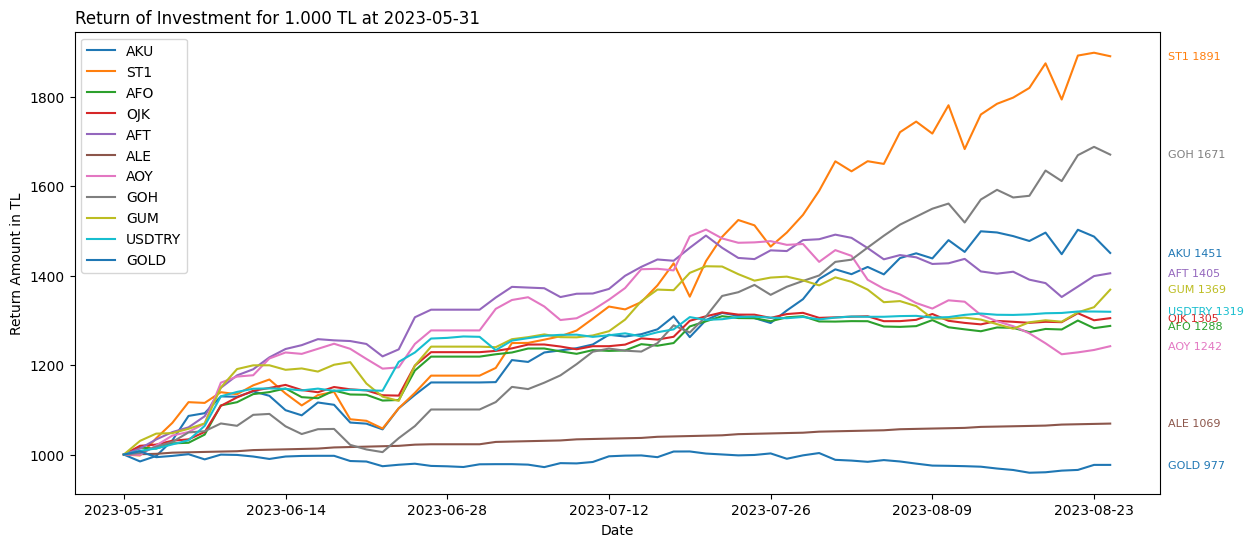

In [14]:
import matplotlib.pyplot as plt

ax = df_normalized.plot(kind="line",figsize=(14,6))

for line, name in zip(ax.lines, df.columns):
    y = line.get_ydata()[-1]
    ax.annotate(name + ' ' + str(round(y)), xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=8, va="center")

plt.title("Return of Investment for 1.000 TL at "+str(date_start), loc = 'left')
plt.xlabel("Date")
plt.ylabel("Return Amount in TL")
plt.show()


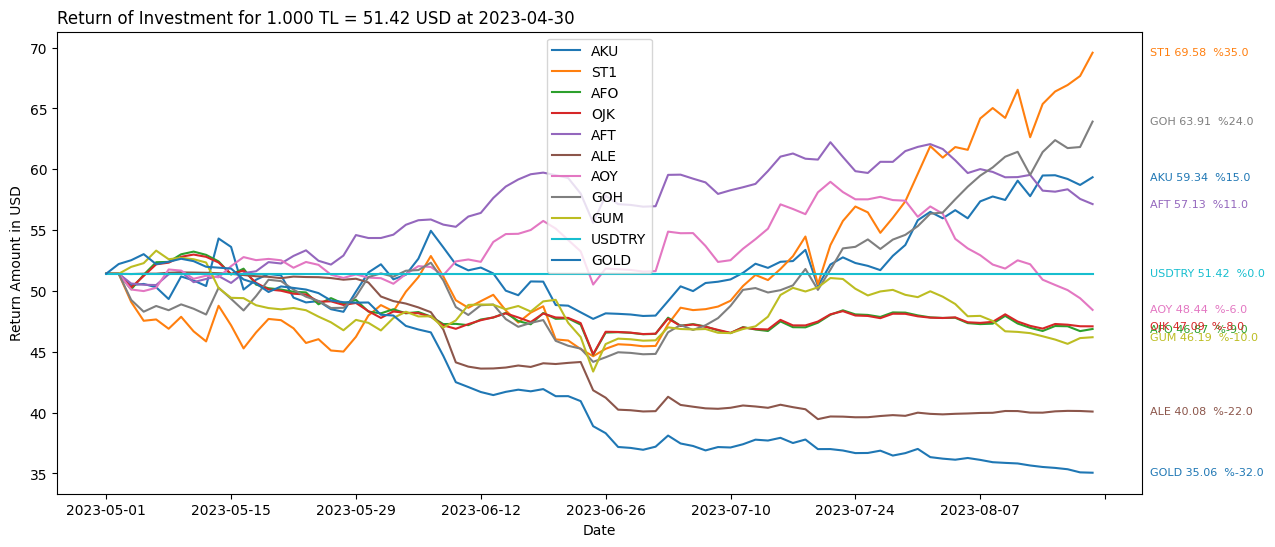

In [ ]:
import matplotlib.pyplot as plt

ax = df_normalized_USD.plot(kind="line",figsize=(14,6))

for line, name in zip(ax.lines, df.columns):
    y = line.get_ydata()[-1]
    strt = line.get_ydata()[0]
    ax.annotate(name + ' ' + str(round(y,2)) + '  %' +str( round((y - strt)/strt,2)*100) , xy=(1,y), xytext=(6,0), color=line.get_color(), xycoords = ax.get_yaxis_transform(), textcoords="offset points", size=8, va="center")

plt.title("Return of Investment for 1.000 TL = " + str(round(df_normalized_USD.iloc[0,0],2)) + " USD at "+str(date_start), loc = 'left')
plt.xlabel("Date")
plt.ylabel("Return Amount in USD")
plt.show()

# Analyze Options

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(df_normalized_USD)
print(mu)

S = risk_models.sample_cov(df)

#optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Max Sharpe Results")
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

ef = EfficientFrontier(mu, S)
weights = ef.max_quadratic_utility()
cleaned_weights = ef.clean_weights()
print("Max Quadratic Utility")
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

AKU       5.797803e-01
ST1       1.624414e+00
AFO      -2.555749e-01
OJK      -2.445224e-01
AFT       3.999359e-01
ALE      -5.480446e-01
AOY      -1.731364e-01
GOH       1.002061e+00
GUM      -2.893584e-01
USDTRY    6.661338e-16
GOLD     -7.052173e-01
dtype: float64
Max Sharpe Results
OrderedDict([('AKU', 0.0), ('ST1', 0.4235), ('AFO', 0.0), ('OJK', 0.0), ('AFT', 0.28718), ('ALE', 0.0), ('AOY', 0.0), ('GOH', 0.28932), ('GUM', 0.0), ('USDTRY', 0.0), ('GOLD', 0.0)])
Expected annual return: 109.3%
Annual volatility: 28.0%
Sharpe Ratio: 3.83
Max Quadratic Utility
OrderedDict([('AKU', 0.0), ('ST1', 1.0), ('AFO', 0.0), ('OJK', 0.0), ('AFT', 0.0), ('ALE', 0.0), ('AOY', 0.0), ('GOH', 0.0), ('GUM', 0.0), ('USDTRY', 0.0), ('GOLD', 0.0)])
Expected annual return: 162.4%
Annual volatility: 43.5%
Sharpe Ratio: 3.69


(1.6244148637240425, 0.43462651406423924, 3.6914794928661547)